In [1]:
import os
import math
from tensorflow import keras
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Activation

from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# GPU Configurations

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  0


In [3]:
basedir = "./dataset/" # here below the train and validation data

In [4]:
def removeCorruptedImages(path):
    for filename in os.listdir(path):
        try:
            img = Image.open(os.path.join(path,filename))
            img.verify() 
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            os.remove(os.path.join(path,filename))

In [5]:
# Yoga Set 1
yoga_train_path = os.path.join("yoga_set1","train") # root for training
yoga_test_path = os.path.join("yoga_set1","test") # root for testing

# Yoga Set 2
# yoga_train_path = os.path.join("yoga_set2","train") # root for training
# yoga_test_path = os.path.join("yoga_set2","test") # root for testing

traindir = os.path.join(basedir,yoga_train_path) 
validdir = os.path.join(basedir,yoga_test_path) 

In [6]:

# Yoga Set 1
removeCorruptedImages(os.path.join(traindir,'tree'))
removeCorruptedImages(os.path.join(traindir,'downdog'))
removeCorruptedImages(os.path.join(traindir,'warrior1'))

removeCorruptedImages(os.path.join(validdir,'tree'))
removeCorruptedImages(os.path.join(validdir,'downdog'))
removeCorruptedImages(os.path.join(validdir,'warrior1'))


# Yoga Set 2
# removeCorruptedImages(os.path.join(traindir,'goddess'))
# removeCorruptedImages(os.path.join(traindir,'mountain'))
# removeCorruptedImages(os.path.join(traindir,'warrior2'))

# removeCorruptedImages(os.path.join(validdir,'goddess'))
# removeCorruptedImages(os.path.join(validdir,'mountain'))
# removeCorruptedImages(os.path.join(validdir,'warrior2'))


## Image Data Generator

In [7]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [8]:
batch_size=8
print("For Training: ")
train_datagen = train_datagen.flow_from_directory(
                  directory = traindir,
                  target_size=(300,300),
                  batch_size=batch_size,
                  shuffle=True,
                  color_mode="rgb",
                  class_mode='categorical')

print("\nFor Testing: ")
val_datagen = test_datagen.flow_from_directory(
                directory = validdir,
                target_size=(300,300),
                batch_size=batch_size,
                shuffle=False,
                color_mode="rgb",
                class_mode='categorical')

For Training: 
Found 1312 images belonging to 3 classes.

For Testing: 
Found 219 images belonging to 3 classes.


In [9]:
# Loading Pretrained Model

# base_model_path2 = "./pretrained_models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
# base_model =  Xception(weights=base_model_path1, include_top=False, input_shape=(300, 300, 3))

base_model_path1 = "./pretrained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(weights=base_model_path1, include_top=False, input_shape=(300, 300, 3))

In [10]:
output_neurons = 3

model = Sequential()
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(output_neurons))
model.add(Activation('softmax'))


model = Model(inputs=base_model.input, outputs=model(base_model.output))


optimizers = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
losss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(loss=losss,
             optimizer=optimizers,
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [11]:
# Callbacks

class ConvolutionCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>=0.97 and logs.get('val_accuracy') >=0.92):
                print("Reached greater than 97.0% accuracy so cancelling training!")
                self.model.stop_training = True
                
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.001, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint("./checkpoints_models/pose_classification_model_weights2.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

convolutionCallback = ConvolutionCallback()
callbacks = [PlotLossesKerasTF(), checkpoint,reduce_lr, convolutionCallback]

## Training

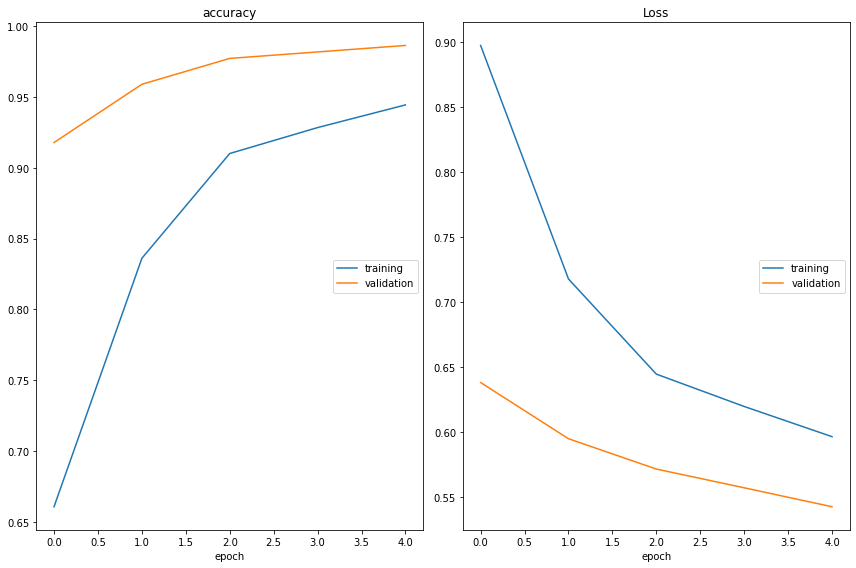

accuracy
	training         	 (min:    0.661, max:    0.944, cur:    0.944)
	validation       	 (min:    0.918, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.597, max:    0.898, cur:    0.597)
	validation       	 (min:    0.543, max:    0.638, cur:    0.543)

Epoch 00005: saving model to ./checkpoints_models\pose_classification_model_weights2.h5


In [12]:
# epoch_for_model2 = 5
BATCH_SIZE = 16

history = model.fit(train_datagen,
                    epochs=4,
                    validation_data = val_datagen,
                    callbacks=callbacks
                    )

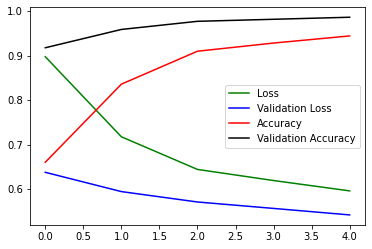

In [14]:
plt.figure(0)
plt.plot(history.history['loss'],'g', label="Loss")
plt.plot(history.history['val_loss'],'b',label="Validation Loss")
plt.plot(history.history['accuracy'],'r', label="Accuracy")
plt.plot(history.history['val_accuracy'],'black', label="Validation Accuracy")
plt.legend()
plt.show()

## Saving Model

In [30]:
yoga_set1_model_save_path = "./final_models/H5_Models/Yoga_Set1.h5"
# yoga_set2_model_save_path = "./final_models/H5_Models/Yoga_Set2.h5"
model.save(yoga_set2_model_save_path)

In [31]:
loaded_model = tf.keras.models.load_model('./final_models/H5_Models/Yoga_Set1.h5')
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [17]:
## TFLite Import

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

yoga_final_model_name = "Yoga_Set1_TFLite_Model.tflite"
# yoga_final_model_name = "Yoga_Set2_TFLite_Model.tflite"

tflite_model_name = yoga_final_model_name
open(tflite_model_name,"wb").write(tflite_model)

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')
    
convert_bytes(get_file_size(tflite_model_name),"MB")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function canonicalize_signatures.<locals>.signature_wrapper at 0x0000017EB92DF400>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function canonicalize_signatures.<locals>.signature_wrapper at 0x0000017EB92DF400>. 

## Testing 

In [ ]:
model.evaluate(val_datagen)

22/28 [======================>.......] - ETA: 10s - loss: 0.5402 - accuracy: 0.9886

In [19]:
yoga_labels = {0:"downdog",1:"tree",2:"warrior1"}
# yoga_labels = {0:"goddess",1:"mountain",2:"warrior2"}

Enter Image Name (from 1-15) : 8


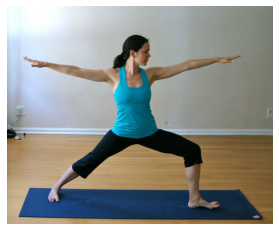

Class Predictions:  [[2.4243561e-24 6.4264106e-23 1.0000000e+00]]

Prediction is:  warrior2


In [29]:
import numpy as np
from keras.preprocessing import image
import matplotlib.image as mpimg

# predicting images
path = input("Enter Image Name (from 1-15) : ")
path = "./dataset/final_test/yoga_set1/" + path + ".jpg"

img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
# print(x/255)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = loaded_model.predict(images, batch_size=10)

plt.axis("Off")
img = mpimg.imread(path)
plt.imshow(img)
plt.show()

print("Class Predictions: ",classes)
pred_index = np.argmax(classes[0])
print("\nPrediction is: ", yoga_labels[pred_index])